# Simulación 1DOF de Dinámica del Cohete (Algoritmo MIT) + supersónico
Santiago Arroyo Lozano

## Contexto
Aiuda por favor, estoy tratando de simular el cohete híbrido de 9km que acaban de dimensionar Matías y Max. Para el flujo másico sumé los datos del flujo másico de la cámara ded combustión más el tanque oxidante. <br>

Finalmente interpolé la curva de empuje y del flujo másico para usarlas. Todos los datos salen chuecos!

In [91]:
"""
@author Santiago Arroyo
@date 20/11/2023

Simulacion de cohete unidimensional
"""
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.interpolate import interp1d
from scipy.constants import speed_of_sound, pi

def air_density(altitude):
    # Esta es una simplificación; se podría usar la ecuación barométrica para mayor precisión
    return rho * np.exp(-altitude/8500)  # Decremento exponencial de la densidad con la altura

default_factory = (lambda: None)
      
# Definimos los diccionarios que nos ayudaran a graficar
grafica_peso = defaultdict(default_factory)
grafica_fuerza = defaultdict(default_factory)
grafica_altura = defaultdict(default_factory)
grafica_inercia = defaultdict(default_factory)
grafica_impulso = defaultdict(default_factory)
grafica_arrastre = defaultdict(default_factory)
grafica_velocidad = defaultdict(default_factory)
grafica_aceleracion = defaultdict(default_factory)
grafica_mach = defaultdict(default_factory)
grafica_cd = defaultdict(default_factory)

# Datos motor
file_path = './MegaPunisher2.csv'
empuje_datos = pd.read_csv(file_path)

thrust = empuje_datos['Thrust (N)']
tiempo_empuje = empuje_datos['Time (s)']
fuel_mass_flow_rate = empuje_datos['Fuel Mass Flow Rate (kg/s)']
oxidizer_mass_flow_rate = empuje_datos['Oxidizer Mass Flow Rate (kg/s)']

# Suma de las tasas de flujo en kg/s
total_mass_flow_rate = fuel_mass_flow_rate + oxidizer_mass_flow_rate

# Interpolaciones. Pasamos m_fuel a g/s
interp_m_fuel = interp1d(tiempo_empuje, total_mass_flow_rate*1000, fill_value="extrapolate")
interp_empuje = interp1d(tiempo_empuje, thrust, fill_value="extrapolate")

#Definimos nuestros datos iniciales
salio_riel = False
h_0 = 0
rho = 1.225           # Densidad del aire al nivel del mar en kg/m^3
g = 9.807             # Gravedad
D = 0                 # Arrastre
m = 44                # Masa en kg
F = 0                 # Fuerza en N
T = 0                 # Thrust(Impulso) en N
p = 1.2               # Densidad del aire en CDMX
h = 0                 # Altura (inica con valor 0)
V = 0                 # velocidad (inica con valor 0)
C_D = 0.5             # Coeficiente de arrastre constante
delta_t = 0.2         # Tasa de cambio del tiempo
m_fuel = 0            # Flujo de masa (Combustible): g/s
r = 0.1524            # Radio del fuselaje en metros, despues de pasarlo de pulgadas
A = pi*r**2           # Area de superficie en m. 
longitud_riel = 6     # metros
N_M = 0               # Numero de mach

# Iniciamos con las iteraciones
for t in np.arange(0,10.2,delta_t):
#     t = round(t,2) #Debemos redondear por problemas de Python con los números flotantes
    T = interp_empuje(t)
    m_fuel = interp_m_fuel(t)
    if V >= 0:
        F = -m*g-D+T
    else:
        F = -m*g+D-T
    rho = air_density(h)
    a = F/m #acel
    h = h + V*(t-(t-delta_t)) #altura
    m = m - (m_fuel*(t-(t-delta_t))) #masa
    I = 1/2*m*r**2 #Fórmula de momento de incercia de un cuerpo cilíndrico
    V = V + a*t #Vel
    W = m*g # Fórmula de peso en relacióna masa y gravedad
    
    if not(salio_riel) and h < h_0:
        V = 0;
        h = h_0 + 0.001; 
    
    if h > h_0+6:
        salioDelRiel = True;
    
    # Calcular el número de Mach y ajustar el coeficiente de arrastre
    Mach = V / speed_of_sound
    if Mach > 1:
        # Suponiendo que C_D aumenta después de Mach 1; usar un modelo más preciso es recomendable
        C_D *= 1.2
    
    # Calcular el arrastre
    D = 0.5 * rho * V**2 * C_D * A
    D = round((1/2)*p*(V**2)*C_D*A, 2) #Debemos redondear a dos dígitos para evitar overlfow
    
    if h >= longitud_riel and bandera:
        vel_riel = V
        bandera = True
    
    # Guardamos los valores en sus respectivos diccionarios
    grafica_peso[t] = W
    grafica_mach[t] = Mach
    grafica_cd[Mach] = D
    grafica_fuerza[t] = F
    grafica_altura[t] = h
    grafica_inercia[t] = I
    grafica_impulso[t] = T
    grafica_arrastre[t] = D
    grafica_velocidad[t] = V
    grafica_aceleracion[t] = a
    
    # Cuando la altura sea cero quiere decir que estamos en Tierra nuevamente, termina la simulación. 
    # En caso contrario seguimos
#     if h <= 0 and t > 1:
#         break
print(f'La velocidad de salida del riel es {vel_riel:.2f} m/s')

La velocidad de salida del riel es -8.90 m/s


# Graficamos los resultados:

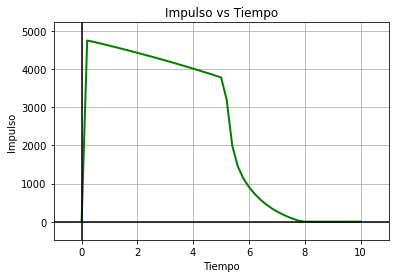

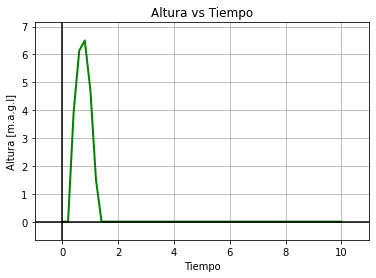

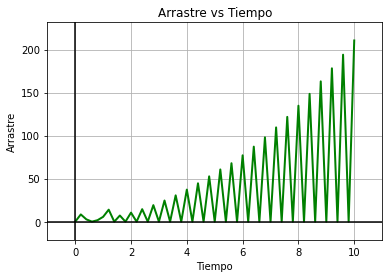

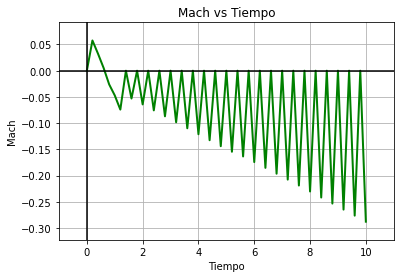

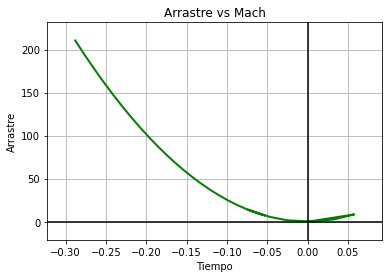

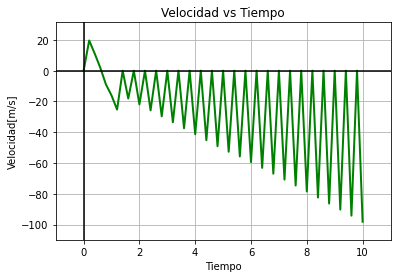

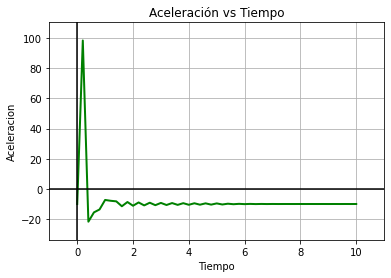

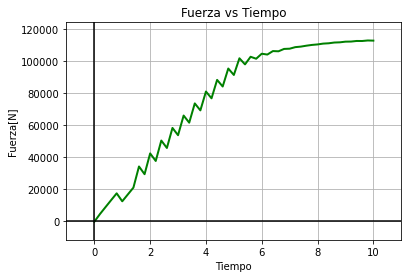

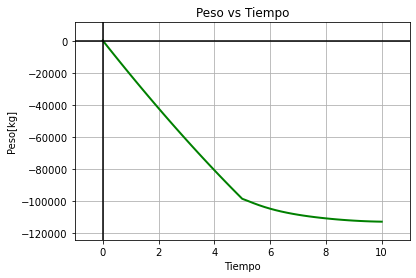

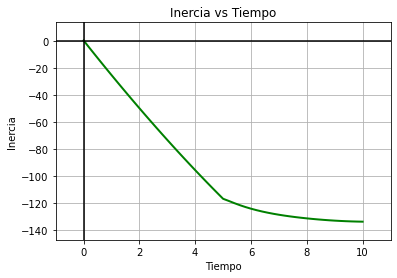

In [90]:
import matplotlib.pyplot as plt

# Lista de diccionarios de datos
graficas = [
    (grafica_impulso, 'Impulso', 'Impulso vs Tiempo'),
    (grafica_altura, 'Altura [m.a.g.l]', 'Altura vs Tiempo'),
    (grafica_arrastre, 'Arrastre', 'Arrastre vs Tiempo'),
    (grafica_mach, 'Mach', 'Mach vs Tiempo'),
    (grafica_cd, 'Arrastre', 'Arrastre vs Mach'),
    (grafica_velocidad, 'Velocidad[m/s]', 'Velocidad vs Tiempo'),
    (grafica_aceleracion, 'Aceleracion', 'Aceleración vs Tiempo'),
    (grafica_fuerza, 'Fuerza[N]', 'Fuerza vs Tiempo'),
    (grafica_peso, 'Peso[kg]', 'Peso vs Tiempo'),
    (grafica_inercia, 'Inercia', 'Inercia vs Tiempo')
]

for datos, ylabel, title in graficas:
    # Calcular el máximo y mínimo para los límites del eje Y
    max_value = max(datos.values())
    min_value = min(datos.values())

    # Ajustar la cota si se desea un margen
    margen_y = (max_value - min_value) * 0.1
    cota_y_min = min_value - margen_y
    cota_y_max = max_value + margen_y

    # Calcular el mínimo y máximo tiempo para los límites del eje X
    cota_x_min = min(datos.keys())
    cota_x_max = max(datos.keys())

    # Ajustar la cota si se desea un margen
    margen_x = (cota_x_max - cota_x_min) * 0.1
    cota_x_min -= margen_x
    cota_x_max += margen_x

#     plt.plot(datos.keys(), datos.values(), color='green', linewidth=3, marker='o', markerfacecolor='blue', markersize=6)
    plt.plot(datos.keys(), datos.values(), color='green', linewidth=2, markerfacecolor='blue', markersize=6)
    plt.ylim(cota_y_min, cota_y_max)
    plt.xlim(cota_x_min, cota_x_max) 
    plt.xlabel('Tiempo')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.show()

El valor final de $t$ es el tiempo total de la simulación

In [18]:
t

10.0

**Ejericio Avionica**<br>
Adjunta un programa funcional (en el lenguaje que sea) que reciba un dato numérico a la vez, imprima los tres últimos datos (incluyendo el que se acaba de ingresar) y el promedio de estos tres. Repetir indefinidamente, que pida otro dato y se deseche el más antiguo y vuela a imprimir los datos y el promedio. Es obligatorio ocupar un arreglo, y máximo dos variables escalares. (No se pueden usar colas u otra estructura de datos) *
1 punto


In [ ]:
"""
@author Santiago Arroyo
@date 05/09/2021
Debido a que como tal los arreglos de Python son en realidad listas doblemente ligadas, 
    usaremos una libreria que nos ayudará a ser más eficientes con la memoria y darle vida a un arreglo de verdad    
"""
from array import *
i = resultado = 0
arreglo = array('i', [1,2,3,4,5]) #‘i’ -> Respresenta entero de tamaño de 2 bytes
while True:
    try:
        arreglo[i] = int(input("Por favor introduce un número: "))
        i += 1
        if i >= 3:
            i = 0
            resultado = (arreglo[0]+arreglo[1]+arreglo[2])/3
            print("El primer dato fue", arreglo[0])
            print("El segundo dato fue", arreglo[1])
            print("El tercer dato fue", arreglo[2])
            print("El resultado es: ", resultado)   
    except ValueError:
        print("Oops!  Por favor inserta un número válido.")